# Analyze met data at each site
- overview of the met data
- overview of stability
- overview of evaluation observations: snow depth and surface temperature

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

# Original Swamp Angel observations
dirDataRaw = dirPre + 'GroundObs/SenatorBeck/Raw'

## Open data

In [3]:
os.chdir(dirData)
SWA = xr.open_dataset('SWA.ModTsfc.nc')
SNQ = xr.open_dataset('SNQ.ModTsfc.nc')
CDP = xr.open_dataset('CDP.ModTsfc.nc')

In [4]:
# --------------------------------------------------------------------------------------------
# Add bulk stability measure to each site
RiBulk,_,_ = turbpy.bulkRichardson(SWA.Tair + 273.15, SWA.Tsrf + 273.15, SWA.WIND, 6 - SWA.snowDepth)
SWA['RiBulk'] = RiBulk
RiBulk,_,_ = turbpy.bulkRichardson(SNQ.Tair + 273.15, SNQ.Tsrf + 273.15, SNQ.WIND, 6 - SNQ.snowDepth)
SNQ['RiBulk'] = RiBulk
RiBulk,_,_ = turbpy.bulkRichardson(CDP.Tair + 273.15, CDP.Tsrf + 273.15, CDP.WIND, 6 - CDP.snowDepth)
CDP['RiBulk'] = RiBulk

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in multiply
  if not reflexive


In [5]:
# --------------------------------------------------------------------------------------------
# Resample to daily
dailyResample = True
if dailyResample:
    # Other accounting
    SWA_daily = SWA.resample(how='mean', freq='d', dim='time')
    SNQ_daily = SNQ.resample(how='mean', freq='d', dim='time')
    CDP_daily = CDP.resample(how='mean', freq='d', dim='time')

    os.chdir(dirData)
    SWA_daily.to_netcdf('SWA.ModTsfc.Daily.nc')
    SNQ_daily.to_netcdf('SNQ.ModTsfc.Daily.nc')
    CDP_daily.to_netcdf('CDP.ModTsfc.Daily.nc')

# Load daily resamples
else:
    SWA_daily = xr.open_netcdf('SWA.ModTsfc.Daily.nc')
    SNQ_daily = xr.open_netcdf('SNQ.ModTsfc.Daily.nc')
    CDP_daily = xr.open_netcdf('CDP.ModTsfc.Daily.nc')

# --------------------------------------------------------------------------------------------
# Dictionaries for iterating
met = {'SWA': SWA,
       'SNQ': SNQ,
       'CDP': CDP}

metDaily = {'SWA_daily': SWA_daily,
            'SNQ_daily': SNQ_daily,
            'CDP_daily': CDP_daily}

## Functions

In [6]:
# --------------------------------------------------------------------------------------------
# Groupby water year
def water_year(time_index, last_month=9):
    '''
    Example usage:
    wy = SNOTEL.groupby(water_year(SNOTEL.t))
    Returns a groupby object of wy. Allows iteration by water year. A little clunky to use still...
    '''
    year = time_index.to_index().year
    year[time_index.to_index().month > last_month] += 1 
    return xr.DataArray(year, dims=time_index.dims, coords=time_index.coords, name='water_year')

In [8]:
def metOverview(dat, siteName):
    fig, axes = plt.subplots(3, 2, sharex=True, figsize=(15, 8))
    axes = axes.flatten()
    fig.suptitle(siteName)
    
    # solar
    yMaxSWdwn = 400
    yMinSWdwn = 0
    ax = axes[0]
    ax.plot(dat.time, dat.SWdwn)
    ax.fill_between(dat.time.values, yMinSWdwn, yMaxSWdwn, where=(dat.SP == 1), alpha=0.5, facecolor='0.6')
    ax.set_ylim(yMinSWdwn, yMaxSWdwn)
    ax.set_ylabel('Wm$^{-2}$')
    ax.set_title('Daily Solar')

    # longwave
    yMaxLWdwn = 400
    yMinLWdwn = 0
    ax = axes[1]
    ax.plot(dat.time, dat.LWdwn)
    ax.fill_between(dat.time.values, yMinLWdwn, yMaxLWdwn, where=(dat.SP == 1), alpha=0.5, facecolor='0.6')
    ax.set_ylim(yMinLWdwn, yMaxLWdwn)
    ax.set_ylabel('Wm$^{-2}$')
    ax.set_title('Daily Longwave')

    # Tair
    yMaxTair = 20
    yMinTair = -20
    ax = axes[2]
    ax.plot(dat.time, dat.Tair)
    ax.fill_between(dat.time.values, yMinTair, yMaxTair, where=(dat.SP == 1), alpha=0.5, facecolor='0.6')    
    ax.set_ylim(yMinTair, yMaxTair)
    ax.set_ylabel('$^{\circ}$C')
    ax.set_title('Daily Air Temp')

    # RH
    yMaxRH = 100
    yMinRH = 0
    ax = axes[3]
    ax.plot(dat.time, dat.RH)
    ax.fill_between(dat.time.values, yMinRH, yMaxRH, where=(dat.SP == 1), alpha=0.5, facecolor='0.6')        
    ax.set_ylim(yMinRH, yMaxRH)
    ax.set_ylabel('%')
    ax.set_title('Daily Humidity')

    # Precip
    # Need to turn this into water year accumulated precip
    yMaxPrecip = dat.precip.max() + dat.precip.mean(dim='time')
    yMinPrecip = 0
    ax = axes[4]
    ax.plot(dat.time, dat.precip)
    ax.fill_between(dat.time.values, yMinPrecip, yMaxPrecip, where=(dat.SP == 1), alpha=0.5, facecolor='0.6')
    ax.set_ylim(yMinPrecip, yMaxPrecip)
    ax.set_ylabel('mm/day')
    ax.set_title('Daily Precip')

    # Wind
    yMaxWind = 10
    yMinWind = 0
    ax = axes[5]
    ax.plot(dat.time, dat.WIND)
    ax.fill_between(dat.time.values, yMinWind, yMaxWind, where=(dat.SP == 1), alpha=0.5, facecolor='0.6')
    ax.set_ylim(yMinWind, yMaxWind)
    ax.set_ylabel('ms$^{-1}$')
    ax.set_title('Daily Wind')

    fig.autofmt_xdate()

In [9]:
def snowOverview(dat, siteName):
    fig, axes = plt.subplots(2, 1, sharex=True)
    axes = axes.flatten()
    fig.suptitle(siteName)
    
    # snow depth
    yMaxSnowDepth = dat.snowDepth.max() + dat.snowDepth.max() / 10
    yMinSnowDepth = 0
    ax = axes[0]
    ax.plot(dat.time, dat.snowDepth)
    ax.fill_between(dat.time.values, yMinSnowDepth, yMaxSnowDepth, where=(dat.SP == 1), alpha=0.5, facecolor='0.6')
    ax.set_ylim(yMinSnowDepth, yMaxSnowDepth)
    ax.set_ylabel('mm')
    ax.set_title('Snow Depth (m)')

    # Tsurf
    yMaxTsurf = 20
    yMinTsurf = -30
    ax = axes[1]
    ax.plot(dat.time, dat.snowTs, label='snow')
    ax.plot(dat.time, dat.groundTs, label='snow free')
    ax.fill_between(dat.time.values, yMinTsurf, yMaxTsurf, where=(dat.SP == 1), alpha=0.5, facecolor='0.6')
    ax.set_ylim(yMinTsurf, yMaxTsurf)
    ax.legend(loc='best')
    ax.set_ylabel('$^{\circ}$ C')
    ax.set_title('Daily Tsurf')

    fig.autofmt_xdate()

SWA_daily
SNQ_daily
CDP_daily


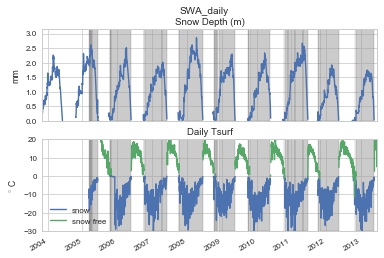

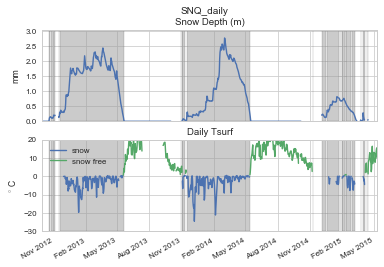

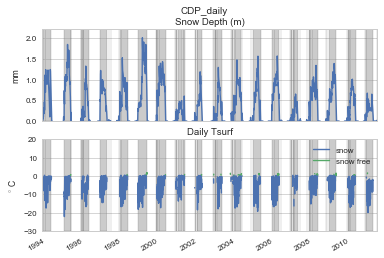

In [10]:
for stat in metDaily:
    print(stat)
    snowOverview(metDaily[stat], stat)

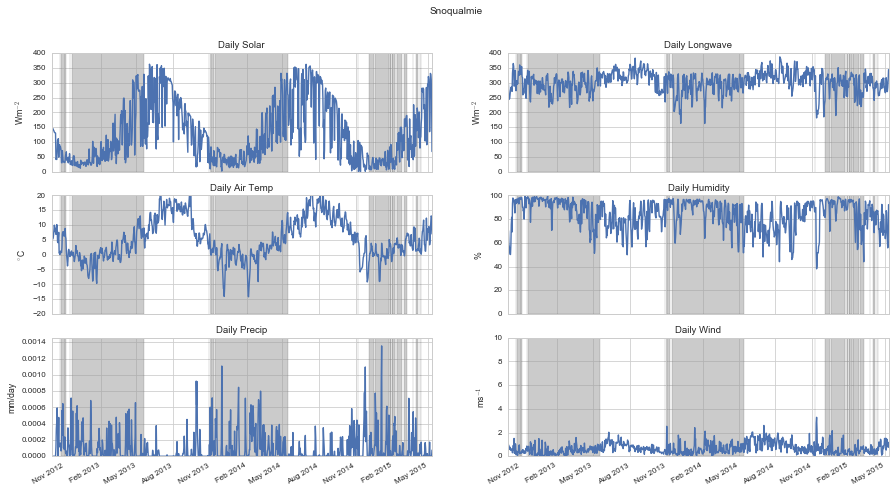

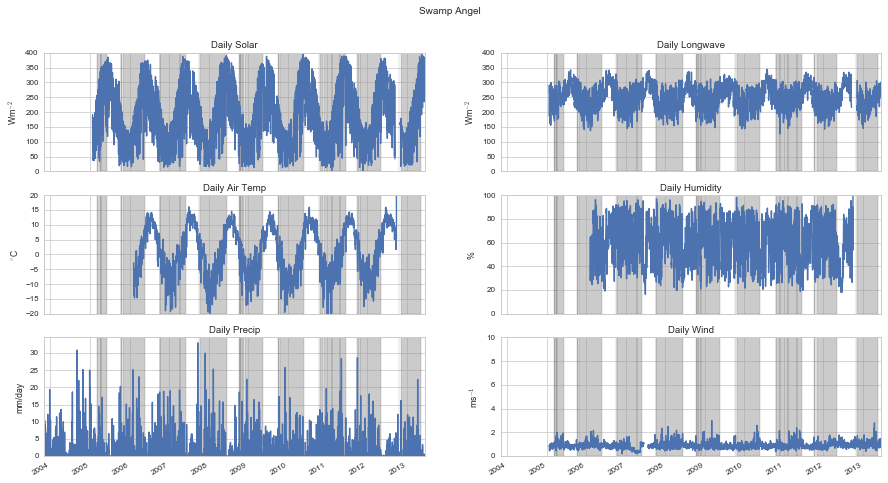

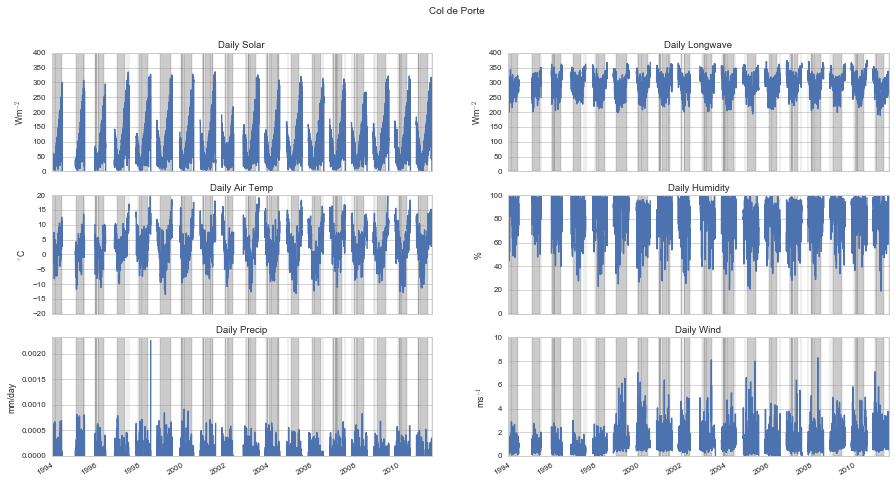

In [11]:
# Plot met over view
metOverview(SNQ_daily, 'Snoqualmie')
metOverview(SWA_daily, 'Swamp Angel')
metOverview(CDP_daily, 'Col de Porte')

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


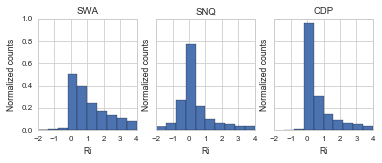

In [12]:
# Bulk stability overview
fig, axes = plt.subplots(1, 3, figsize=(6, 2), sharey=True)
axes = axes.flatten()
for n, site in enumerate(met):
    ax = axes[n]
    ax.hist(met[site].RiBulk, range=(-2, 4), normed=True)
    ax.set_xlabel('Ri')
    ax.set_ylabel('Normalized counts')
    ax.set_title(site)